In [1]:
import pickle
import copy
import torch
import time
import numpy as np
np.set_printoptions(precision = 4)
import matplotlib.pyplot as plt
import sys
sys.path.append('./../')


from datasets.dataset import _load_collection_real,_load_collection_syn,_load_collection_uci_data
from models_utility.construct_models import _initialize_SMkernelhyp,_make_gpmodel
from utility.eval_metric import _evaluate_metric
import random
from kernels.RBF_kernel import RBF
from kernels.SM_kernel import SM
from scipy.linalg import norm as fnorm


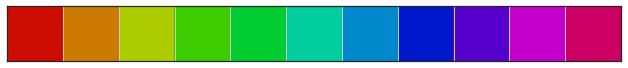

In [2]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(10+1, l=.4, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [3]:
device = False

setting_dict = {}
random_seed = 1000
setting_dict['random_seed'] = random_seed
setting_dict['init_sample_num'] = 100
setting_dict['lr_hyp'] = 1e-3         #0.001,0.0005  error -- >0.0001 equal_reg
setting_dict['kl_option'] = True   #['True','False']
setting_dict['num_batch'] = 1
setting_dict['tau0'] = 1000
setting_dict['iter'] = 4000        #[5000,8000]
setting_dict['num_rep'] = 2
setting_dict['weight_rate'] = 1e-3  # [1e-2,1e-3,1e-5]
setting_dict['optimizer'] = 'Adam'   #['SGD','Adam']

In [4]:
import numpy as np
import copy

def _initialize_SMkernel_hyp_v2(  setting_dict, random_seed,weight_option):
    """

    :param y_train:
    :param setting_dict: num_Q,input_dim
    :param random_seed:
    :return:
    """

    np.random.seed(random_seed)
    Num_Q = setting_dict['num_Q']
    SMKernel_hyp = {}


    input_dim = setting_dict['input_dim']
    if weight_option is True:
        SMKernel_hyp['weight'] = 20*np.random.rand(Num_Q).reshape(-1, 1)
    else:
        SMKernel_hyp['weight'] = (0.49 + 0.02*np.random.rand(Num_Q)).reshape(-1, 1)

        
        
    SMKernel_hyp['std'] = 0.05*np.random.rand(Num_Q ,input_dim)
    SMKernel_hyp['std_prior'] = 0.05*np.random.rand(Num_Q ,input_dim)
    SMKernel_hyp['mean'] = 5*np.random.rand(Num_Q ,input_dim)
    SMKernel_hyp['mean_prior'] = 0.5*np.zeros((Num_Q, input_dim))

    
    SMKernel_hyp['noise_variance'] = 1.0  # real v2
    setting_dict['hypparam'] = SMKernel_hyp

    return copy.deepcopy(setting_dict)


In [5]:
Q = 10
setting_dict['input_dim'] = 1
setting_dict['num_Q'] = Q
setting_dict['noise_err'] = .05
setting_dict1 = _initialize_SMkernel_hyp_v2(setting_dict, random_seed ,weight_option=True)
setting_dict2 = _initialize_SMkernel_hyp_v2(setting_dict, random_seed ,weight_option=False)

In [6]:
sm_kernel1 = SM(weight=setting_dict1['hypparam']['weight'] , mu=setting_dict1['hypparam']['mean'], std=setting_dict1['hypparam']['std'] ,device= device)
sm_kernel2 = SM(weight=setting_dict2['hypparam']['weight'] , mu=setting_dict2['hypparam']['mean'], std=setting_dict2['hypparam']['std'] ,device= device)

In [7]:
sm_kernel1.weight,sm_kernel2.weight

(weight : tensor([[ 2.5705],
         [ 0.8330],
         [ 2.9447],
         [ 2.2663],
         [ 2.8593],
         [ 1.4461],
         [-0.2056],
         [ 2.0724],
         [ 1.5396],
         [ 2.8234]], dtype=torch.float64), weight : tensor([[-0.6870],
         [-0.7087],
         [-0.6753],
         [-0.6939],
         [-0.6784],
         [-0.7047],
         [-0.7117],
         [-0.6973],
         [-0.7039],
         [-0.6796]], dtype=torch.float64))

In [8]:
hz = 200
x_train = torch.from_numpy(np.linspace(0,2-1/hz,hz)).view(-1,1)
K1 = sm_kernel1.K(x_train)
K1 += 1e-8*torch.eye(hz)
L1 = torch.cholesky(K1)
y_train1  = (L1.mm(torch.randn(hz,1).double()) + setting_dict['noise_err']*torch.randn(hz,1)).clone().detach()

K2 = sm_kernel2.K(x_train)
K2 += 1e-8*torch.eye(hz)
L2 = torch.cholesky(K2)
y_train2  = (L2.mm(torch.randn(hz,1).double()) + setting_dict['noise_err']*torch.randn(hz,1)).clone().detach()

In [9]:
#save_figure_path = './demo'    

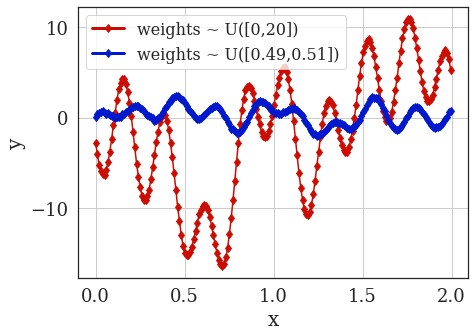

In [10]:
color_tag = current_palette[[0,1,4,7,8]] 

figsiz = (7,5)
plt.figure(figsize=figsiz)
plt.plot(x_train.cpu().data.numpy(),y_train1.cpu().data.numpy(),color = color_tag[0],linestyle='-',marker='d',label = r'weights ~ U([0,20])')
plt.plot(x_train.cpu().data.numpy(),y_train2.cpu().data.numpy(),color = color_tag[-2],linestyle ='-',marker='d',label = r'weights ~ U([0.49,0.51])')

plt.xticks([0,0.5,1.0,1.5,2.0],fontsize = 18)
plt.yticks([-10,0,10],fontsize = 18)
plt.xlabel('x',fontsize = 20)
plt.ylabel('y',fontsize = 20)

leg = plt.legend(loc='best',fontsize = 16.0, ncol = 1 , columnspacing = 0.2)
for line in leg.get_lines():
    line.set_linewidth(3)    

# save_figname= 'exp1_signals'
# plt.savefig(save_figure_path + save_figname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()    


In [11]:
def _run_exp(setting_dict0, device, comparison_variable_list, num_Q , weight_option, x_train, y_train , num_rep = 100):
    digts = 4
    #setting_dict0[]
    #setting_dict0['num_Q'] = num_Q
    #setting_dict0 = _initialize_SMkernel_hyp_v2(x_train, y_train, setting_dict, random_seed ,weight_option= weight_option)

    
    ew_fro_mean, ew_fro_std = [],[]
    ew2_fro_mean, ew2_fro_std = [],[]
    ew3_fro_mean, ew3_fro_std = [],[]
    nw_fro_mean, nw_fro_std = [],[]
    e_fro_mean, e_fro_std = [],[]
    
    ew_losserr_mean, ew_losserr_std = [],[]
    ew2_losserr_mean, ew2_losserr_std = [],[]
    ew3_losserr_mean, ew3_losserr_std = [],[]
    nw_losserr_mean, nw_losserr_std = [],[]
    e_losserr_mean, e_losserr_std = [],[]
    
    #comparison_variable_list = [2,3,5,10,20] # sampled spectral points

    gpsm = _make_gpmodel(model_name='gpsm', setting_dict=setting_dict0, device=device)
    gpsm._set_data(x_train,y_train)
    num_input = x_train.shape[0]
    sm = gpsm._compute_Kxx(x_train).cpu().data.numpy() + (gpsm.likelihood.variance.transform()**2).cpu().data.numpy()*np.eye(num_input)     
    sm_norm = fnorm(sm,'fro')
    
    print(setting_dict0['hypparam']['weight'])
    #print(x_train,y_train)
    
    exact_loss = gpsm.compute_loss(x_train,y_train,kl_option=True).squeeze().cpu().data.numpy()
    for ith_sample in comparison_variable_list:
        #print(filename + ' ' +str(ith_sample))
        #print('filename: {}, Q: {}, spt: {}'.format(filename,Q,ith_sample))
        print('Q: {}, spt: {}'.format(Q,ith_sample))


        #setting_dict0['num_sample_pt'] = Q*ith_sample    
        setting_dict0['num_sample_pt'] = ith_sample    
    
    
        rrff_equal = _make_gpmodel(model_name='equal_reg', setting_dict=setting_dict0, device=device)
        rrff_equal._set_data(x_train,y_train)        
        #print( 'rff_equal.num_samplept_list_at '+ str(rrff_equal.num_samplept_list_at))
        
        rrff_naive_weight = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict0, device=device)
        rrff_naive_weight.sampling_option = 'naive_weight'
        rrff_naive_weight._set_data(x_train,y_train ) 

        rrff_naive_weight._assign_num_spectralpt(x_train , intrain = True)
        
        rrff_exact_weight = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict0, device=device)
        rrff_exact_weight.spt_manager.rate = 1.0
        rrff_exact_weight._set_data(x_train,y_train) 
        
        rrff_exact_weight_v2 = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict0, device=device)
        #rrff_exact_weight_v2.spt_manager.rate = .05    
        rrff_exact_weight_v2.spt_manager.rate = .2    
        
        rrff_exact_weight_v2._set_data(x_train,y_train)           
       
    
        rrff_exact_weight_v3 = _make_gpmodel(model_name='weight_reg', setting_dict=setting_dict0, device=device)
        #rrff_exact_weight_v3.spt_manager.rate = .1   
        rrff_exact_weight_v3.spt_manager.rate = .1   
        
        rrff_exact_weight_v3._set_data(x_train,y_train)              
        
        
        # -----------------------------------
        # existing
        # ------------------------------------
        rrff_equal._assign_num_spectralpt(x_train,intrain= True)        
        rrff_exact_weight._assign_num_spectralpt(x_train , intrain = True)        
        rrff_exact_weight_v2._assign_num_spectralpt(x_train , intrain = True)        
        rrff_exact_weight_v3._assign_num_spectralpt(x_train , intrain = True)        
        

        
        
        ew_fro,ew2_fro,ew3_fro,ew4_fro,nw_fro,e_fro = [],[],[],[],[],[]
        ew_losserr,ew2_losserr,ew3_losserr,ew4_losserr,nw_losserr,e_losserr = [],[],[],[],[],[]

        for i in range(num_rep):
            #print('exact_w')            
            asm_ew = rrff_exact_weight._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()
            #print('exact_w')            
            asm_ew_v2 = rrff_exact_weight_v2._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()
            #print('exact_w')                        
            asm_ew_v3 = rrff_exact_weight_v3._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()
            #print('exact_nw')            
            asm_nw = rrff_naive_weight._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()        
            #print('exact_ne')                        
            asm_e = rrff_equal._compute_kernel_sm_approximate(x = x_train).cpu().data.numpy()    
            ew_fro.append(fnorm(sm-asm_ew,'fro'))
            ew2_fro.append(fnorm(sm-asm_ew_v2,'fro'))
            ew3_fro.append(fnorm(sm-asm_ew_v3,'fro'))
            nw_fro.append(fnorm(sm-asm_nw,'fro'))
            e_fro.append(fnorm(sm-asm_e,'fro'))        

        #print('\n'*10)

        rrff_exact_weight._assign_num_spectralpt(x_train , intrain = True)
        rrff_exact_weight_v2._assign_num_spectralpt(x_train , intrain = True)
        rrff_exact_weight_v3._assign_num_spectralpt(x_train , intrain = True)        
            
        for i in range(num_rep):              
            #print('exact_w')
            ew_loss = rrff_exact_weight._compute_nlml(x_train,y_train).squeeze().cpu().data.numpy()
            #print('exact_w')
            ew2_loss = rrff_exact_weight_v2._compute_nlml(x_train,y_train).squeeze().cpu().data.numpy()
            #print('exact_w')
            ew3_loss = rrff_exact_weight_v3._compute_nlml(x_train,y_train).squeeze().cpu().data.numpy()            
            #print('naive_nw')
            nw_loss = rrff_naive_weight._compute_nlml(x_train,y_train).squeeze().cpu().data.numpy() 
            #print('naive_ew')
            e_loss = rrff_equal._compute_nlml(x_train,y_train).squeeze().cpu().data.numpy()
            ew_losserr.append( ew_loss - exact_loss  )
            ew2_losserr.append( ew2_loss - exact_loss )
            ew3_losserr.append( ew3_loss - exact_loss )
            nw_losserr.append( nw_loss - exact_loss  )
            e_losserr.append( e_loss - exact_loss  )        
            
        
        # ---------------------------------------------------
        # fnorm
        # ---------------------------------------------------        
        ew_fro_mean.append(np.around(np.asarray(ew_fro).mean(),digts))
        ew_fro_std.append(np.around(np.asarray(ew_fro).std(),digts))
        
        ew2_fro_mean.append(np.around(np.asarray(ew2_fro).mean(),digts))
        ew2_fro_std.append(np.around(np.asarray(ew2_fro).std(),digts))

        ew3_fro_mean.append(np.around(np.asarray(ew3_fro).mean(),digts))
        ew3_fro_std.append(np.around(np.asarray(ew3_fro).std(),digts))

        nw_fro_mean.append(np.around(np.asarray(nw_fro).mean(),digts))
        nw_fro_std.append(np.around(np.asarray(nw_fro).std(),digts))

        e_fro_mean.append(np.around(np.asarray(e_fro).mean(),digts))
        e_fro_std.append(np.around(np.asarray(e_fro).std(),digts))

        # ---------------------------------------------------
        # loss err
        # ---------------------------------------------------      
        ew_losserr_mean.append(np.around(np.asarray(ew_losserr).mean(),digts))
        ew_losserr_std.append(np.around(np.asarray(ew_losserr).std(),digts))
        
        ew2_losserr_mean.append(np.around(np.asarray(ew2_losserr).mean(),digts))
        ew2_losserr_std.append(np.around(np.asarray(ew2_losserr).std(),digts))

        ew3_losserr_mean.append(np.around(np.asarray(ew3_losserr).mean(),digts))
        ew3_losserr_std.append(np.around(np.asarray(ew3_losserr).std(),digts))

        nw_losserr_mean.append(np.around(np.asarray(nw_losserr).mean(),digts))
        nw_losserr_std.append(np.around(np.asarray(nw_losserr).std(),digts))

        e_losserr_mean.append(np.around(np.asarray(e_losserr).mean(),digts))
        e_losserr_std.append(np.around(np.asarray(e_losserr).std(),digts))
        

        print(ew_fro_mean,ew_fro_std)
        print(ew2_fro_mean,ew2_fro_std)    
        print(ew3_fro_mean,ew3_fro_std)    
        print(nw_fro_mean,nw_fro_std)    
        print(e_fro_mean,e_fro_std)

        print('')

    return ew_fro_mean,ew_fro_std,\
           ew2_fro_mean,ew2_fro_std,\
           ew3_fro_mean,ew3_fro_std,\
           nw_fro_mean,nw_fro_std,\
           e_fro_mean,e_fro_std,\
           ew_losserr_mean,ew_losserr_std,\
           ew2_losserr_mean,ew2_losserr_std,\
           ew3_losserr_mean,ew3_losserr_std,\
           nw_losserr_mean,nw_losserr_std,\
           e_losserr_mean,e_losserr_std
       

### repetitive experiment

In [12]:
#num_repexp = 500
num_repexp = 500

## experiments over varying SPT

In [13]:
num_Q_list = [10]
comparison_variable_list = [4,7,10]

In [14]:
ew_fro_mean_list,ew_fro_std_list = [],[]
ew2_fro_mean_list,ew2_fro_std_list = [],[]
ew3_fro_mean_list,ew3_fro_std_list = [],[]
nw_fro_mean_list,nw_fro_std_list = [],[]
e_fro_mean_list,e_fro_std_list = [],[]

ew_losserr_mean_list,ew_losserr_std_list = [],[]
ew2_losserr_mean_list,ew2_losserr_std_list = [],[]
ew3_losserr_mean_list,ew3_losserr_std_list = [],[]
nw_losserr_mean_list,nw_losserr_std_list = [],[]
e_losserr_mean_list,e_losserr_std_list = [],[]

### extremely different weight initialzation

In [15]:
for num_Q in num_Q_list:
    print(num_Q)
    ew_fro_mean,ew_fro_std,\
    ew2_fro_mean,ew2_fro_std,\
    ew3_fro_mean,ew3_fro_std,\
    nw_fro_mean,nw_fro_std,\
    e_fro_mean,e_fro_std,\
    ew_losserr_mean,ew_losserr_std,\
    ew2_losserr_mean,ew2_losserr_std,\
    ew3_losserr_mean,ew3_losserr_std,\
    nw_losserr_mean,nw_losserr_std,\
    e_losserr_mean,e_losserr_std= _run_exp(setting_dict1,device,comparison_variable_list, num_Q, True, x_train,y_train1,num_repexp)

    ew_fro_mean_list.append(ew_fro_mean)
    ew_fro_std_list.append(ew_fro_std)
    
    ew2_fro_mean_list.append(ew2_fro_mean)
    ew2_fro_std_list.append(ew2_fro_std)

    ew3_fro_mean_list.append(ew3_fro_mean)
    ew3_fro_std_list.append(ew3_fro_std)

    nw_fro_mean_list.append(nw_fro_mean)
    nw_fro_std_list.append(nw_fro_std)

    e_fro_mean_list.append(e_fro_mean)
    e_fro_std_list.append(e_fro_std)

    
    ew_losserr_mean_list.append(ew_losserr_mean)
    ew_losserr_std_list.append(ew_losserr_std)
    
    ew2_losserr_mean_list.append(ew2_losserr_mean)
    ew2_losserr_std_list.append(ew2_losserr_std)

    ew3_losserr_mean_list.append(ew3_losserr_mean)
    ew3_losserr_std_list.append(ew3_losserr_std)

    nw_losserr_mean_list.append(nw_losserr_mean)
    nw_losserr_std_list.append(nw_losserr_std)

    e_losserr_mean_list.append(e_losserr_mean)
    e_losserr_std_list.append(e_losserr_std)
    
    

10
[[13.0718]
 [ 2.3001]
 [19.0057]
 [ 9.6438]
 [17.4495]
 [ 4.2467]
 [ 0.8142]
 [ 7.9439]
 [ 4.6626]
 [16.8348]]
Q: 10, spt: 4
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
[280.9665] [109.1692]
[267.0098] [95.3905]
[278.5943] [106.3462]
[278.4077] [102.548]
[295.9101] [119.3185]

Q: 10, spt: 7
total spt:70, spt:7, Q:10 in spt manager
total spt:70, spt:7, Q:10 in spt manager
total spt:70, spt:7, Q:10 in setup model 
total

In [16]:
wspace = .5  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = .4  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
figsiz = (7.2*2,4.4)


# loss err

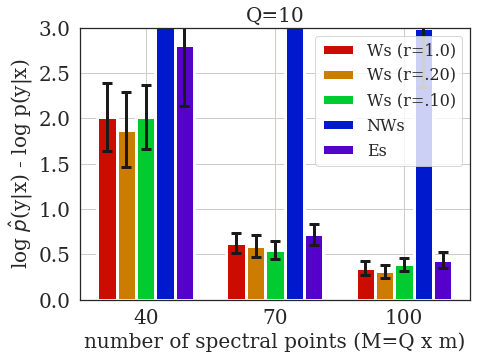

In [20]:
from matplotlib.ticker import StrMethodFormatter


wspace = .25 # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = .085  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
#legend_tag = ['proposed r=1.0','proposed r=0.05','proposed r=0.1','naive weight','equal']
legend_tag2 = ['Ws (r=1.0)','Ws (r=.20)','Ws (r=.10)','NWs','Es']
#legend_tag2 = ['weight r=1.0','weight r=.50','weight r=.10','equal']

color_tag = current_palette[[0,1,4,7,8]] 





c = 20
figsiz = (7,5)
fig = plt.figure(figsize = figsiz)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)


#for ew_fro_mean in num_
for ith in range(len(num_Q_list)):
    width = 0.9  # the width of the bars

    Q_means_list,Q_stds_list = [],[]
    Q_means_list.append( ew_losserr_mean_list[ith])
    Q_means_list.append( ew2_losserr_mean_list[ith])
    Q_means_list.append( ew3_losserr_mean_list[ith])
    Q_means_list.append( nw_losserr_mean_list[ith])
    Q_means_list.append( e_losserr_mean_list[ith])
    
    Q_stds_list.append( ew_losserr_std_list[ith])
    Q_stds_list.append( ew2_losserr_std_list[ith])
    Q_stds_list.append( ew3_losserr_std_list[ith])
    Q_stds_list.append( nw_losserr_std_list[ith])
    Q_stds_list.append( e_losserr_std_list[ith])
    
    
    #ticklabel = [str(i) for i in comparison_variable_Qlist]
    ticklabel = [str(spt*num_Q_list[ith]) for spt in comparison_variable_list]  
    ind = 1*np.arange(len(comparison_variable_list))  # the x locations for the groups
    width = 0.9  # the width of the bars    

    for iith,(ith_mean,ith_std) in enumerate(zip(Q_means_list,Q_stds_list)):
        #plt.bar(ind + (-2+iith)*width/6  , ith_mean , width/6, yerr= ith_std ,linewidth=3 , capsize=5 , label= legend_tag2[iith]  , color = color_tag[iith] )
        plt.bar(ind + (-2+iith)*width/6  , ith_mean , width/6, yerr= 2*np.array(ith_std)/np.sqrt(num_repexp) 
                ,linewidth=3 , error_kw=dict(lw=3, capsize=5, capthick=3) , label= legend_tag2[iith]  , color = color_tag[iith] )

    plt.xticks( ind , ticklabel)
    plt.xlabel('number of spectral points (M=Q x m)',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize= 20)

    
    
    plt.gca().yaxis.get_offset_text().set_size(17)
    plt.title('Q={}'.format(num_Q_list[ith]), fontsize= 20)
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0) )

    if ith == 0:
        plt.ylabel('log $\hat{p}$(y|x) - log p(y|x)',fontsize = 20)


plt.ylim([0,3])
leg = plt.legend(loc='upper right',fontsize = 16.0, ncol = 1 , columnspacing = 0.4)
for line in leg.get_lines():
    line.set_linewidth(4)    
    
    
    
save_figname= 'exp1_weightlosserror'
# plt.savefig(save_figure_path + save_figname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
# plt.show()    




# equal weight inialization

In [21]:
ew_fro_mean_list2,ew_fro_std_list2 = [],[]
ew2_fro_mean_list2,ew2_fro_std_list2 = [],[]
ew3_fro_mean_list2,ew3_fro_std_list2 = [],[]
nw_fro_mean_list2,nw_fro_std_list2 = [],[]
e_fro_mean_list2,e_fro_std_list2 = [],[]

ew_losserr_mean_list2,ew_losserr_std_list2 = [],[]
ew2_losserr_mean_list2,ew2_losserr_std_list2 = [],[]
ew3_losserr_mean_list2,ew3_losserr_std_list2 = [],[]
nw_losserr_mean_list2,nw_losserr_std_list2 = [],[]
e_losserr_mean_list2,e_losserr_std_list2 = [],[]

In [22]:
for num_Q in num_Q_list:
    print(num_Q)
    ew_fro_mean,ew_fro_std,\
    ew2_fro_mean,ew2_fro_std,\
    ew3_fro_mean,ew3_fro_std,\
    nw_fro_mean,nw_fro_std,\
    e_fro_mean,e_fro_std,\
    ew_losserr_mean,ew_losserr_std,\
    ew2_losserr_mean,ew2_losserr_std,\
    ew3_losserr_mean,ew3_losserr_std,\
    nw_losserr_mean,nw_losserr_std,\
    e_losserr_mean,e_losserr_std = _run_exp(setting_dict2,device,comparison_variable_list, num_Q, False, x_train,y_train2,num_repexp)

    
    ew_fro_mean_list2.append(ew_fro_mean)
    ew_fro_std_list2.append(ew_fro_std)
    
    ew2_fro_mean_list2.append(ew2_fro_mean)
    ew2_fro_std_list2.append(ew2_fro_std)

    ew3_fro_mean_list2.append(ew3_fro_mean)
    ew3_fro_std_list2.append(ew3_fro_std)

    nw_fro_mean_list2.append(nw_fro_mean)
    nw_fro_std_list2.append(nw_fro_std)

    e_fro_mean_list2.append(e_fro_mean)
    e_fro_std_list2.append(e_fro_std)
    
    ew_losserr_mean_list2.append(ew_losserr_mean)
    ew_losserr_std_list2.append(ew_losserr_std)
    
    ew2_losserr_mean_list2.append(ew2_losserr_mean)
    ew2_losserr_std_list2.append(ew2_losserr_std)

    ew3_losserr_mean_list2.append(ew3_losserr_mean)
    ew3_losserr_std_list2.append(ew3_losserr_std)

    nw_losserr_mean_list2.append(nw_losserr_mean)
    nw_losserr_std_list2.append(nw_losserr_std)

    e_losserr_mean_list2.append(e_losserr_mean)
    e_losserr_std_list2.append(e_losserr_std)
    
    

10
[[0.5031]
 [0.4923]
 [0.509 ]
 [0.4996]
 [0.5074]
 [0.4942]
 [0.4908]
 [0.4979]
 [0.4947]
 [0.5068]]
Q: 10, spt: 4
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in spt manager
total spt:40, spt:4, Q:10 in setup model 
[15.6716] [4.8957]
[15.2252] [4.6105]
[15.6266] [4.6019]
[16.9936] [5.3465]
[16.7253] [5.4741]

Q: 10, spt: 7
total spt:70, spt:7, Q:10 in spt manager
total spt:70, spt:7, Q:10 in spt manager
total spt:70, spt:7, Q:10 in setup model 
total spt:70, spt:7, Q:10 in

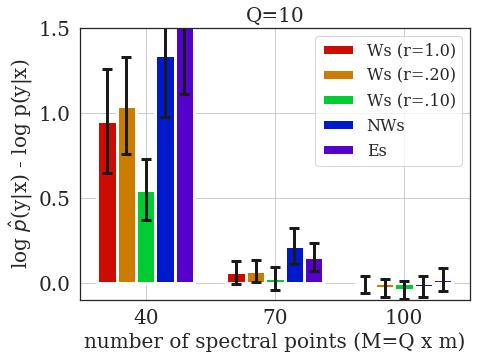

In [27]:
from matplotlib.ticker import StrMethodFormatter


wspace = .25 # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = .085  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
#legend_tag = ['proposed r=1.0','proposed r=0.05','proposed r=0.1','naive weight','equal']
#legend_tag2 = ['weight r=1.0','weight r=.50','weight r=.10','naive weight','equal']
legend_tag2 = ['Ws (r=1.0)','Ws (r=.20)','Ws (r=.10)','NWs','Es']
#legend_tag2 = ['weight r=1.0','weight r=.50','weight r=.10','equal']

color_tag = current_palette[[0,1,4,7,8]] 



c = 20
figsiz = (7,5)
fig = plt.figure(figsize = figsiz)


#for ew_fro_mean in num_
for ith in range(len(num_Q_list)):
    #plt.subplot(1,2,ith+1)
    width = 0.9  # the width of the bars

    Q_means_list,Q_stds_list = [],[]
    Q_means_list.append( ew_losserr_mean_list2[ith])
    Q_means_list.append( ew2_losserr_mean_list2[ith])
    Q_means_list.append( ew3_losserr_mean_list2[ith])
    Q_means_list.append( nw_losserr_mean_list2[ith])
    Q_means_list.append( e_losserr_mean_list2[ith])
    
    Q_stds_list.append( ew_losserr_std_list2[ith])
    Q_stds_list.append( ew2_losserr_std_list2[ith])
    Q_stds_list.append( ew3_losserr_std_list2[ith])
    Q_stds_list.append( nw_losserr_std_list2[ith])
    Q_stds_list.append( e_losserr_std_list2[ith])
    
    
    #ticklabel = [str(i) for i in comparison_variable_Qlist]
    ticklabel = [str(spt*num_Q_list[ith]) for spt in comparison_variable_list]  
    ind = 1*np.arange(len(comparison_variable_list))  # the x locations for the groups
    width = 0.9  # the width of the bars    

    for iith,(ith_mean,ith_std) in enumerate(zip(Q_means_list,Q_stds_list)):
        #plt.bar(ind + (-2+iith)*width/6  , ith_mean , width/6, yerr= ith_std ,linewidth=3 , capsize=5 , label= legend_tag2[iith]  , color = color_tag[iith] )
        plt.bar(ind + (-2+iith)*width/6  , ith_mean , width/6, yerr= 2*np.array(ith_std)/np.sqrt(num_repexp) 
                ,linewidth=3 , error_kw=dict(lw=3, capsize=5, capthick=3) , label= legend_tag2[iith]  , color = color_tag[iith] )

        
    plt.xticks( ind , ticklabel)
    plt.xlabel('number of spectral points (M=Q x m)',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize= 20)
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0) )
    plt.gca().yaxis.get_offset_text().set_size(17)
    #plt.title('M=Q x 3', fontsize= 20)
    plt.title('Q={}'.format(num_Q_list[ith]), fontsize= 20)


    plt.ylim([-.1,1.5])
    
    
    
    if ith == 0:
        plt.ylabel('log $\hat{p}$(y|x) - log p(y|x)',fontsize = 20)

        
leg = plt.legend(loc='upper right',fontsize = 16.0, ncol = 1 , columnspacing = 0.4)

#leg = plt.legend(fontsize = 16.0, ncol = 1 , columnspacing = 0.65)
for line in leg.get_lines():
    line.set_linewidth(4)    


save_figname= 'exp1_equallosserror'
#save_figname= 'exp1_equallosserror_stderr_v22'
# plt.savefig(save_figure_path + save_figname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
# plt.show()    

